**Nome:** Pedro Henrique Silva Domingues

**R.A.:** 122.103-5

### Bibliotecas

In [1]:
import cv2 # OpenCV - Para carregar imagem do disco
import matplotlib.pyplot as plt # Para plot de grafico e exibir imagem
import numpy as np # Para operação em arrays
from functools import partial # Manipular funções
from sklearn.cluster import KMeans # Scikit learn - para usar os algoritmos de clusterização

### Constantes

In [2]:
IMG_PATH = './images/test_image.jpg' # Caminho da imagem que sera utilizada

### Funções auxiliares

In [33]:
# Mostra a imagem no notebook
def show_image(image, ax=None):
    if ax is None:
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    else:
        ax.imshow(image, cmap='gray')
        ax.axis('off')

# Plota o histograma calculado previamente
def plot_histogram(hist, threshold=None, ax=None):
    if ax is None:
        plt.figure()
        plotter = plt
    else:
        plotter = ax
    plotter.bar(range(256), hist)
    if threshold is not None: 
        plotter.axvline(threshold, ls='--', c='red', label=f'threshold ({threshold})')
        plotter.legend()

# Cria o histograma da imagem
def histogram(image, density=False):
    hist, _ = np.histogram(image, bins=256, range=(0, 255))
    return hist

def binarize(img, threshold):
    img_copy = img.copy()
    func = lambda value: 0 if value < threshold else 255
    return np.vectorize(func)(img_copy)

### Carregando dados

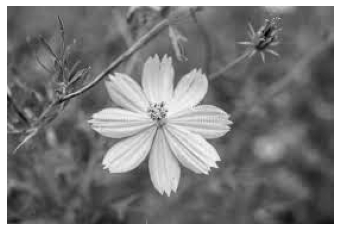

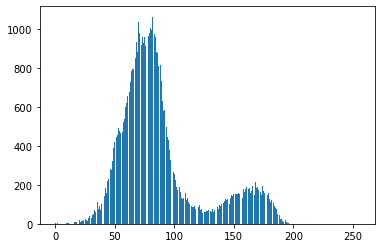

In [4]:
# Load the image
img = cv2.imread(IMG_PATH, 0)
img_histogram = histogram(img)
# Display the image
show_image(img)
# Plot the histogram
plot_histogram(img_histogram)

---

### 1. Segmentar com Limiar adaptativo (1 limiar)

1. Intensidade média: 88.42736214605067


Text(0.5, 1.0, '2. Imagem binarizada com a intensidade média')

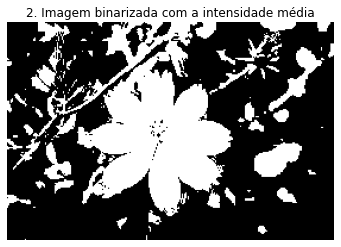

In [5]:
# 1 - Inicialize o limiar T como a média das intensidades;
n_pixels = (img.shape[0]*img.shape[1])
T = np.sum([i*img_histogram[i] for i in range(256)])/n_pixels
print(f'1. Intensidade média: {T}')
# 2 - Binarize a Imagem de Entrada I usando o limiar T
bin_img = binarize(img, T)
show_image(bin_img)
plt.title("2. Imagem binarizada com a intensidade média")
# 3 - Calcule o novo limiar 

---

### 2. Segmentar com Entropia Clássica (1 limiar)

Resultado: 
  - Entropia = 8.54078;
  - Threshold = 102


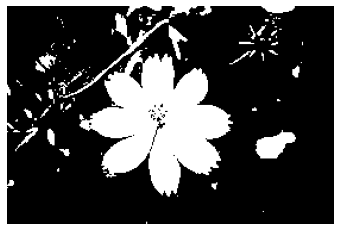

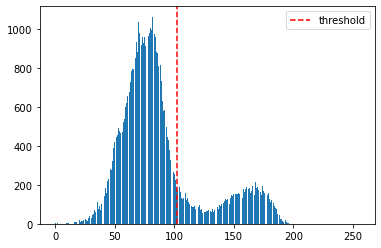

In [6]:
def shannon_entropy(hist):
    if sum(hist) == 0:
        return 0
    # Normaliza o histograma (transforma em uma funcao densidade de probabilidade)
    pdf = hist/sum(hist)
    # Prepara a parte interna do somatório aplicado no calculo da entropia
    func = lambda probability: probability*np.log(probability) if probability > 0 else 0
    # Calcula a entropia
    return -np.sum(np.vectorize(func)(pdf))

best_threshold = {
    'entropy': -1,
    'intensity': None
}
for i in range(1,255): # Inicio em dois pois nos slices do python o valor antes dos : não é inclusivo (ex :2 significa todos os valores até o indice 1)
    # Divide o histograma em dois
    hist_A = img_histogram[:i]
    hist_B = img_histogram[i:]
    # Calcula a entropia de cada trecho e depois a entropia total (soma das duas)
    entropy_A = shannon_entropy(hist_A)
    entropy_B = shannon_entropy(hist_B)
    total_entropy = entropy_A + entropy_B
    # Caso a entropia total seja a maior até agora, salva ela junto ao threshold
    if total_entropy > best_threshold['entropy']:
        best_threshold['entropy'] = total_entropy
        best_threshold['intensity'] = i

print(f"Resultado: \n  - Entropia = {best_threshold['entropy']:.5f};\n  - Threshold = {best_threshold['intensity']}")
show_image(binarize(img, best_threshold['intensity']))
plot_histogram(img_histogram, threshold=best_threshold['intensity'])

---

### 4 - Segmentar com K-means (limiar)

Ponto(s) de corte escolhido(s): 115.13949678278988


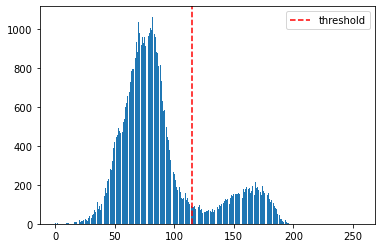

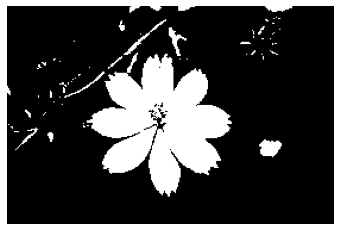

In [7]:
# Carrega o modelo pré implementado do kmeans pela biblioteca scikit-learn
kmeans_model = KMeans(n_clusters=2)
# Fit 2 clusters and find the threashold as the divisory line between them
pixel_labels = kmeans_model.fit_predict(img.reshape(-1,1))
kmeans_threshold = (kmeans_model.cluster_centers_[0][0]+kmeans_model.cluster_centers_[1][0])/2
# Display the result
print(f"Ponto(s) de corte escolhido(s): {kmeans_threshold}")
plot_histogram(img_histogram, threshold=kmeans_threshold)
show_image(binarize(img, kmeans_threshold))

---

### 5 - Segmentar com Entropia Não-Extensiva (1 limiar) usando três valores para q: 1 menor que 1, outro maior que 1, e outro próximo de 1, p.e. 0.999 ou 1.0001

Resultado (q=0.1): 
  - Entropia = 3730.30478;
  - Threshold = 105
Resultado (q=0.9999): 
  - Entropia = 8.54446;
  - Threshold = 102
Resultado (q=6.3): 
  - Entropia = 0.18868;
  - Threshold = 92


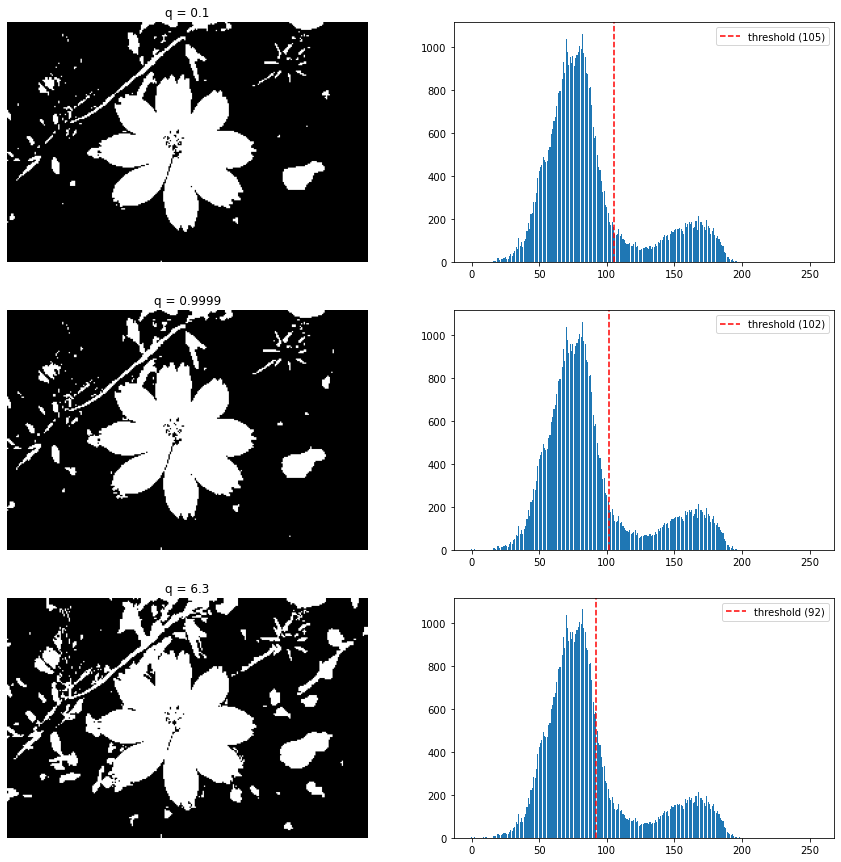

In [34]:
from dit import Distribution
from dit.other import tsallis_entropy

fig, axs = plt.subplots(3,2, figsize=(15,15))

for q, ax in zip((0.1, 0.9999, 6.3), axs):
    entropies = {}
    for i in range(1,255): # Inicio em dois pois nos slices do python o valor antes dos : não é inclusivo (ex :2 significa todos os valores até o indice 1)
        # Divide o histograma em dois
        hist_A = img_histogram[:i]
        hist_B = img_histogram[i:]
        # Funcao Distribuicao de Probabilidade
        if sum(hist_A) > 0:
            # Gera a distribuicao do histograma, necessario apenas para usar a biblioteca
            pdf_A = (hist_A/sum(hist_A))
            # Encontra a entropia maxima (q=0)
            dist_A = Distribution({f'{i:08b}': pdf_A[i] for i in range(len(pdf_A))})
            # Encontra a entropia para o q fornecido (em cada lado)
            Smax_A = tsallis_entropy(dist_A, 0)
            # Encontra a entropia total
            entropy_A = tsallis_entropy(dist_A, q)
            entropy_A = entropy_A if not np.isnan(entropy_A) else 0
        else:
            entropy_A = 0
        if sum(hist_B) > 0:
            pdf_B = (hist_B/sum(hist_B))
            dist_B = Distribution({f'{i:08b}': pdf_B[i] for i in range(len(pdf_B))})
            Smax_B = tsallis_entropy(dist_B, 0)
            entropy_B = tsallis_entropy(dist_B, q)
            entropy_B = entropy_B if not np.isnan(entropy_B) else 0
        else:
            entropy_B = 0
        entropies[i] = entropy_A + entropy_B + (1-q)*entropy_A*entropy_B
        # Imprime uma tabela de valores
        # print(f"q = {q:<3} | i = {i:<3} | S(A) = {entropy_A:<8.5f} | S(B) = {entropy_B:.5f} | Sq = {entropies[i]:.5f}")
        
    # Filtra valores nan (resultados de divisao por zero)
    # entropies = {key: value for key, value in entropies.items() if not np.isnan(value)}
    # Encontra o melhor threshold (menor entropia total)
    best_threshold = max(entropies, key=entropies.get)

    print(f"Resultado (q={q}): \n  - Entropia = {entropies[best_threshold]:.5f};\n  - Threshold = {best_threshold}")

    ax[0].set_title(f"q = {q}")
    show_image(binarize(img, threshold=best_threshold), ax=ax[0])
    plot_histogram(img_histogram, threshold=best_threshold, ax=ax[1])

---

### 6 - Segmentar com Entropia Não-Extensiva (2 limiares). Os valores de q iguais ao da questão 5